In [17]:
# Install necessary libraries
!pip install transformers datasets rouge-score pandas openpyxl matplotlib seaborn tqdm




Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 842.8 kB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datasets import load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration
from rouge_score import rouge_scorer



In [19]:
# Load the CNN/DailyMail dataset
dataset = load_dataset('cnn_dailymail', '3.0.0')


In [24]:
import torch

# Load the pre-trained T5 model and tokenizer
model_name = 't5-small'
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Using device: {device}")


Using device: cuda


In [25]:
# Function to generate summaries using GPU
def generate_summary(text, max_length=150):
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=512, truncation=True).to(device)
    summary_ids = model.generate(inputs, max_length=max_length, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary


In [26]:
# Function to calculate ROUGE scores
def calculate_rouge(references, summaries):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = [scorer.score(ref, summ) for ref, summ in zip(references, summaries)]
    return scores


In [27]:
# Process all entries in the test set
articles = dataset['test']['article']
references = dataset['test']['highlights']

# Generate summaries for all test samples
summaries = []
for article in tqdm(articles, desc="Generating Summaries"):
    summaries.append(generate_summary(article))


Generating Summaries: 100%|██████████| 11490/11490 [1:54:02<00:00,  1.68it/s] 


In [28]:
# Calculate ROUGE scores
rouge_scores = calculate_rouge(references, summaries)


In [30]:
import pandas as pd

# Store results in a DataFrame
data = []
for i in range(len(articles)):
    data.append([
        articles[i],
        references[i],
        summaries[i],
        rouge_scores[i]['rouge1'].fmeasure,
        rouge_scores[i]['rouge2'].fmeasure,
        rouge_scores[i]['rougeL'].fmeasure
    ])

df = pd.DataFrame(data, columns=["Article", "Human Summary", "Generated Summary", "ROUGE-1", "ROUGE-2", "ROUGE-L"])

# First, save as a CSV with UTF-8 encoding
csv_filename = "summarization_results.csv"
df.to_csv(csv_filename, index=False, encoding="utf-8")

# Now read the CSV and convert it to Excel (ensuring compatibility)
excel_filename = "summarization_results.xlsx"
df = pd.read_csv(csv_filename)
df.to_excel(excel_filename, index=False, engine="openpyxl")

print(f"Summarization results saved successfully: {excel_filename}")


Summarization results saved successfully: summarization_results.xlsx


In [31]:
# Calculate average ROUGE scores
avg_rouge1 = df["ROUGE-1"].mean()
avg_rouge2 = df["ROUGE-2"].mean()
avg_rougeL = df["ROUGE-L"].mean()

print(f"\nAverage ROUGE-1: {avg_rouge1:.4f}")
print(f"Average ROUGE-2: {avg_rouge2:.4f}")
print(f"Average ROUGE-L: {avg_rougeL:.4f}")



Average ROUGE-1: 0.3861
Average ROUGE-2: 0.1712
Average ROUGE-L: 0.2720


/tmp/ipykernel_528/2683810058.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["ROUGE-1", "ROUGE-2", "ROUGE-L"], y=[avg_rouge1, avg_rouge2, avg_rougeL], palette="Blues_r")


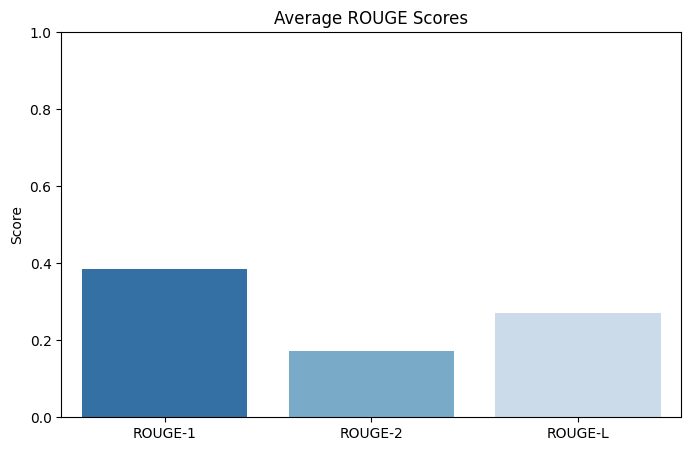

In [32]:
# Bar Chart - Average ROUGE Scores
plt.figure(figsize=(8, 5))
sns.barplot(x=["ROUGE-1", "ROUGE-2", "ROUGE-L"], y=[avg_rouge1, avg_rouge2, avg_rougeL], palette="Blues_r")
plt.title("Average ROUGE Scores")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()


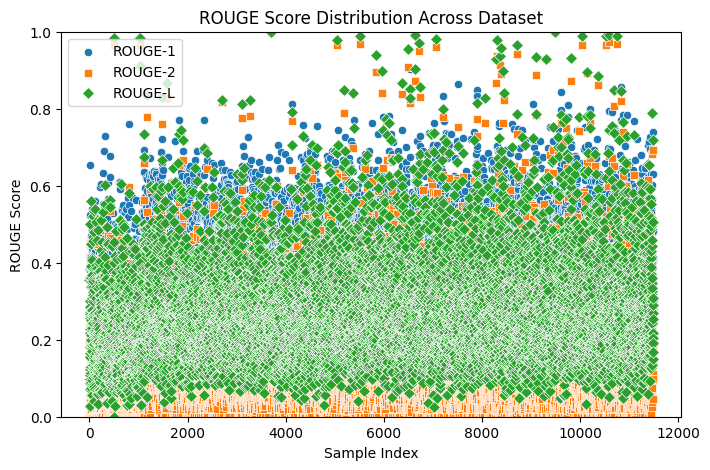

In [33]:
# Scatter Plot - ROUGE Score Distribution
plt.figure(figsize=(8, 5))
sns.scatterplot(x=range(len(df)), y=df["ROUGE-1"], label="ROUGE-1", marker="o")
sns.scatterplot(x=range(len(df)), y=df["ROUGE-2"], label="ROUGE-2", marker="s")
sns.scatterplot(x=range(len(df)), y=df["ROUGE-L"], label="ROUGE-L", marker="D")
plt.title("ROUGE Score Distribution Across Dataset")
plt.xlabel("Sample Index")
plt.ylabel("ROUGE Score")
plt.legend()
plt.ylim(0, 1)
plt.show()


In [9]:
sample_size = 10  # Change this to a larger number if needed
articles = dataset["test"]["article"][:sample_size]
references = dataset["test"]["highlights"][:sample_size]

# Generate summaries
summaries = batch_generate_summaries(articles)


In [10]:
def calculate_rouge(references, summaries):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = [scorer.score(ref, summ) for ref, summ in zip(references, summaries)]
    return scores


In [11]:
rouge_scores = calculate_rouge(references, summaries)


In [12]:
def print_avg_rouge(scores):
    rouge1 = np.mean([score["rouge1"].fmeasure for score in scores])
    rouge2 = np.mean([score["rouge2"].fmeasure for score in scores])
    rougeL = np.mean([score["rougeL"].fmeasure for score in scores])
    
    print(f"Avg ROUGE-1: {rouge1:.4f}")
    print(f"Avg ROUGE-2: {rouge2:.4f}")
    print(f"Avg ROUGE-L: {rougeL:.4f}")

print_avg_rouge(rouge_scores)


Avg ROUGE-1: 0.2484
Avg ROUGE-2: 0.1017
Avg ROUGE-L: 0.1806


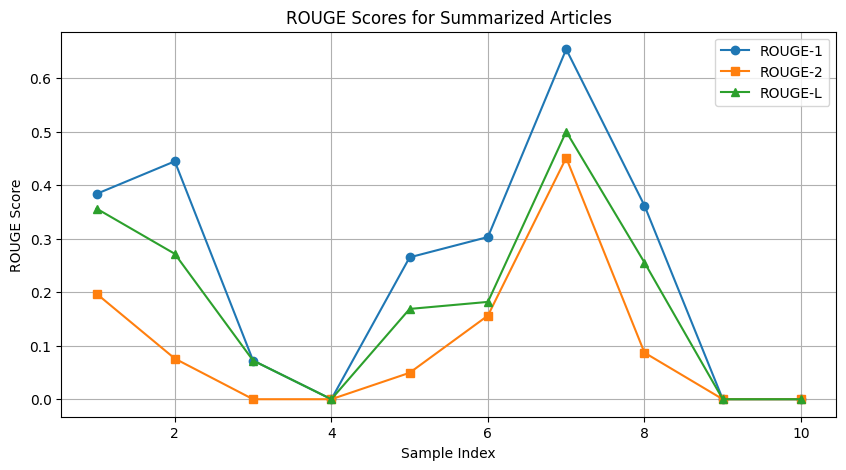

In [13]:
def plot_rouge_scores(scores):
    rouge1 = [score["rouge1"].fmeasure for score in scores]
    rouge2 = [score["rouge2"].fmeasure for score in scores]
    rougeL = [score["rougeL"].fmeasure for score in scores]
    
    x = range(1, len(scores) + 1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(x, rouge1, label="ROUGE-1", marker="o")
    plt.plot(x, rouge2, label="ROUGE-2", marker="s")
    plt.plot(x, rougeL, label="ROUGE-L", marker="^")
    
    plt.xlabel("Sample Index")
    plt.ylabel("ROUGE Score")
    plt.title("ROUGE Scores for Summarized Articles")
    plt.legend()
    plt.grid()
    plt.show()

plot_rouge_scores(rouge_scores)
